In [1]:
#Import libraries and set random seeds 
from pandas import read_csv
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import random
import time
import matplotlib.gridspec as gridspec
import seaborn as sb
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from skopt import  BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l1
from mlxtend.plotting import plot_decision_regions
from tensorflow.keras.optimizers import Adam
from scipy.stats import uniform

seed_value = 7           
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
tf.keras.backend.set_floatx('float64')


In [2]:
#Some functions needed throughout 

def load_data():
    #import data 
    test_filename = 'C:/Users/Max/Documents/Max/Birkbeck/2nd Year/Applied Machine Learning/Coursework/test_imperson_without4n7_balanced_data.csv'
    test_df = read_csv(test_filename, header = None)
    X_test = test_df.iloc[1:, 0:152].reset_index(drop=True)
    Y_test = test_df.iloc[1:, 152:].reset_index(drop=True)
    
    
    #import training data
    train_filename = 'C:/Users/Max/Documents/Max/Birkbeck/2nd Year/Applied Machine Learning/Coursework/train_imperson_without4n7_balanced_data.csv'
    train_df = read_csv(train_filename, header =None)
    X_train = train_df.iloc[1:, 0:152].reset_index(drop=True)
    Y_train = train_df.iloc[1:, 152:].reset_index(drop=True)
    
    return X_train, X_test, Y_train, Y_test

def normalise(X_train, X_test):
    cols = X_train.columns
    norm = MinMaxScaler()
    X_train = norm.fit_transform(X_train)
    X_test = norm.transform(X_test)
    
    return pd.DataFrame(X_train, columns = cols), pd.DataFrame(X_test, columns = cols)

def standardise(X_train, X_test):
    cols = X_train.columns
    stand = StandardScaler()
    X_train = stand.fit_transform(X_train)
    X_test = stand.transform(X_test)
    
    return pd.DataFrame(X_train, columns = cols), pd.DataFrame(X_test, columns = cols)

def delete_zero_var(X_train, X_test):
    ##Delete any features that have a variance of 0.
    list_to_remove = []
    for i in range(0, X_train.shape[1]):
        if (X_train.var()[X_train.columns[i]] == 0) == True:
            list_to_remove.append(i)
            
    new_X_train = X_train.drop(X_train.columns[list_to_remove], axis = 1)
    new_X_test = X_test.drop(X_test.columns[list_to_remove], axis = 1)
    
    return new_X_train, new_X_test

def correlation_remove(X_train, X_test):
    ##Deletes any features that have a correlation of 1 with another 
    ## feature, implying they are identical to each other. 
    correlations = X_train.corr()
    list_of_cols = set()
    
    increment = 0
    
    for i in range(0, correlations.shape[0]):
        for j in range(increment, correlations.shape[0]):
            if correlations.index[j] == correlations.columns[i]:
                pass
            else:
                if correlations.values[j, i] == 1.0:
                    list_of_cols.add(correlations.index[j])
            
        increment += 1
                    
    X_train = X_train.drop(X_train[list_of_cols], axis = 1)
    X_test = X_test.drop(X_test[list_of_cols], axis = 1)
            
    return X_train, X_test

def sae(X_train, X_test, code_size = 2, loss = 'binary_crossentropy',
        epochs = 5, optimizer = 'adam'):

    ##Function to implement a stacked autoencoder to
    ## generate features from training dataset
  
    
    input_size = X_train.shape[1] 
    hidden_1_size = input_size//2
    code_size = code_size
    
    my_init = keras.initializers.glorot_uniform(seed=7)
    
    stacked_encoder = keras.models.Sequential([
        keras.layers.Dense(input_size, activation = 'relu',
                           kernel_initializer=my_init),
        keras.layers.Dense(hidden_1_size, activation = 'relu',
                           kernel_initializer=my_init),
        keras.layers.Dense(code_size, activation = 'relu',
                           activity_regularizer=(l1(10e-6)),
                           kernel_initializer=my_init)])
    
    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(hidden_1_size, activation = 'relu',
                           input_shape = [code_size],
                           kernel_initializer=my_init),
        keras.layers.Dense(input_size, activation = 'sigmoid',
                           kernel_initializer=my_init)])
    
    stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss=loss,
                       optimizer = optimizer)
    stacked_ae.fit(X_train, X_train, epochs = epochs)
    
    sae_train = pd.DataFrame(stacked_encoder.predict(X_train)).add_prefix('sae_')
    sae_test = pd.DataFrame(stacked_encoder.predict(X_test)).add_prefix('sae_')
    
    X_train = pd.concat((pd.DataFrame(X_train), sae_train), axis = 1)
    X_test = pd.concat((pd.DataFrame(X_test), sae_test), axis = 1)
    
    return X_train, X_test

def sae_deep(X_train, X_test, code_size = 2, loss = 'binary_crossentropy',
        epochs = 5, optimizer = 'adam'):

    ##Function to implement a stacked autoencoder to
    ## generate features from training dataset
    
    input_size = X_train.shape[1] 
    neuron_diff = (input_size-code_size)/3
    hidden_1_size = input_size-neuron_diff
    hidden_2_size = hidden_1_size-neuron_diff
    
    code_size = code_size
    my_init = keras.initializers.glorot_uniform(seed=7)
    
    stacked_encoder = keras.models.Sequential([
        keras.layers.Dense(input_size, activation = 'relu', kernel_initializer=my_init),
        keras.layers.Dense(hidden_1_size, activation = 'relu', kernel_initializer=my_init),
        keras.layers.Dropout(.2),
        keras.layers.Dense(hidden_2_size, activation = 'relu', kernel_initializer=my_init),
        keras.layers.Dense(code_size, activation = 'relu', activity_regularizer=(l1(10e-6)), kernel_initializer=my_init)])
    
    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(hidden_2_size, activation = 'relu', input_shape = [code_size], kernel_initializer=my_init),
        keras.layers.Dropout(.2),
        keras.layers.Dense(hidden_1_size, activation = 'relu', kernel_initializer=my_init),
        keras.layers.Dense(input_size, activation = 'sigmoid', kernel_initializer=my_init)])
    
    stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss=loss, optimizer = optimizer)
    stacked_ae.fit(X_train, X_train, epochs = epochs)
    
    sae_train = pd.DataFrame(stacked_encoder.predict(X_train)).add_prefix('sae_')
    sae_test = pd.DataFrame(stacked_encoder.predict(X_test)).add_prefix('sae_')
    
    X_train = pd.concat((pd.DataFrame(X_train), sae_train), axis = 1)
    X_test = pd.concat((pd.DataFrame(X_test), sae_test), axis = 1)
    
    return X_train, X_test

def k_cluster(X_train, X_test, n_clusters = 12, normalise = True):
    ##Kmeans clustering to generate normalised extra feature  
    kmeans = KMeans(n_clusters = n_clusters, random_state=(7))
    kmeans_train = kmeans.fit(X_train)
    kmeans_test = kmeans.predict(X_test)
    
    cluster_train = pd.DataFrame(kmeans_train.labels_)
    cluster_test = pd.DataFrame(kmeans_test)
    
    if normalise == True:
        X_train['cluster'] = cluster_train/n_clusters
        X_test['cluster'] = cluster_test/n_clusters
    else:
        X_train['cluster'] = cluster_train
        X_test['cluster'] = cluster_test
        
    return X_train, X_test
     
def pca(X_train, X_test, var_explained = .97):
    ##PCA 
    pca_model = PCA(var_explained)
    pca_train_features = pca_model.fit_transform(X_train)
    pca_test_features = pca_model.transform(X_test)
    
    pca_train_features = pd.DataFrame(pca_train_features).add_prefix('pca_')
    pca_test_features = pd.DataFrame(pca_test_features).add_prefix('pca_')
    
    X_train = pd.concat((X_train, pca_train_features), axis = 1)
    X_test = pd.concat((X_test, pca_test_features), axis = 1)
    
    return X_train, X_test

def select_features( X_train, X_test, Y_train, num_features = 50):
    ## Use ExtraTreesclassifier and SelectKBest socring methods to 
    # grade each feature. Allocate score to each methods returned 
    # features in descending order and choose best n number of features

    ##ExtraTreesClassifier to evaluate importance of features  
    model = ExtraTreesClassifier(random_state=7)
    extra_trees_class = model.fit(X_train, Y_train)
    features_normalised = np.std([trees.feature_importances_ for trees
                                  in extra_trees_class.estimators_], axis = 0)
    
    features_normalised = pd.DataFrame(features_normalised, index = X_train.columns)
    ExT_feat_sort = features_normalised.sort_values(by=[0], ascending = False)
    
    ##SelectKBest on training data
    select_best = SelectKBest(k='all')
    best_model = select_best.fit(X_train, Y_train)
    sk_scores = pd.DataFrame(best_model.scores_, index = X_train.columns)
    SKBest_feat_sort = sk_scores.sort_values(by=[0], ascending = False)
    
    scores = pd.DataFrame(0, index = [0], columns=X_train.columns)
    fe_scores = [SKBest_feat_sort, ExT_feat_sort]
    
    for score in fe_scores:
        for i in range(0, len(score[0])):
            feat_name = score.iloc[i].name
            scores.loc[0, feat_name] += i
    scores = scores.sort_values(by=0, axis = 1)
    
    features = scores.iloc[:, 0:num_features]
    
    #Select them from training and test sets
    X_train = X_train.loc[:, features.columns]
    X_test = X_test.loc[:, features.columns]
    
    return X_train, X_test, features

def cross_val(model, X_train, Y_train, n_splits = 5):
  kfold = KFold(n_splits=n_splits)
  c_val = cross_val_score(model, X_train, Y_train, cv=kfold)
  return c_val.mean()

def test_score(model, X_test, Y_test):
  model_preds = model.predict(X_test)
  class_report = classification_report(Y_test, model_preds, output_dict= True)
  confusion_mat = confusion_matrix(Y_test, model_preds)
  return class_report, confusion_mat

In [18]:
#Load datasets
X_train, X_test, Y_train, Y_test = load_data()
overview = []

In [19]:
#Train a logistic regression model on 10 best selected features
X_train_best, X_test_best, features = select_features(X_train, X_test, Y_train, num_features = 10)

log_model = LogisticRegression().fit(X_train_best, Y_train)
kfold = KFold(n_splits=5)
cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()

log_predict = log_model.predict(X_test_best)
class_report = classification_report(Y_test, log_predict, output_dict=True)
print(class_report)

overview.append(['log reg baseline on 10 best', features.columns.values, cross_val_mean, class_report['accuracy']])


C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   1   2   7   8   9  10  14  16  18  19  20  21  22  24  25  27  28
  29  30  31  32  33  34  36  37  38  39  41  42  43  46  50  51  52  53
  54  55  56  57  60  62  66  71  78  82  84  88  89  92  93  96  97  98
  99 100 111 112 113 121 128 129 131 132 133 134 136 144 145 146 147 148
 149 150] are constant.
  warnings.warn("Features %s a

{'0': {'precision': 0.9908494028847645, 'recall': 0.9545296080482095, 'f1-score': 0.9723504642078027, 'support': 20079}, '1': {'precision': 0.9561374009128033, 'recall': 0.9911848199611535, 'f1-score': 0.9733457230889618, 'support': 20079}, 'accuracy': 0.9728572140046815, 'macro avg': {'precision': 0.973493401898784, 'recall': 0.9728572140046815, 'f1-score': 0.9728480936483823, 'support': 40158}, 'weighted avg': {'precision': 0.9734934018987841, 'recall': 0.9728572140046815, 'f1-score': 0.9728480936483822, 'support': 40158}}


In [20]:
#Standardise data
X_train_stand, X_test_stand = standardise(X_train, X_test)

In [21]:
#Perform PCA to get reduced number of features and append to original dataset
X_train_pca, X_test_pca = pca(X_train_stand, X_test_stand, var_explained=.9)

In [22]:
#Select top 10 pca features and train logisitc regression model
X_train_best, X_test_best, features = select_features(X_train_pca, X_test_pca, Y_train, num_features = 10)

log_model = LogisticRegression().fit(X_train_best, Y_train)
cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()

log_predict = log_model.predict(X_test_best)
class_report = classification_report(Y_test, log_predict, output_dict=True)
print(class_report)

overview.append(['log reg on pca 10 best features', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

{'0': {'precision': 0.999703826560834, 'recall': 0.8405299068678719, 'f1-score': 0.9132328670761073, 'support': 20079}, '1': {'precision': 0.8624334078020278, 'recall': 0.9997509836147218, 'f1-score': 0.9260292930457847, 'support': 20079}, 'accuracy': 0.9201404452412969, 'macro avg': {'precision': 0.9310686171814309, 'recall': 0.9201404452412969, 'f1-score': 0.919631080060946, 'support': 40158}, 'weighted avg': {'precision': 0.9310686171814309, 'recall': 0.9201404452412969, 'f1-score': 0.919631080060946, 'support': 40158}}


C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [23]:
#Normalise the data
X_train_norm, X_test_norm = normalise(X_train, X_test)

In [24]:
#Train an SAE and append features to original dataset
X_train_sae, X_test_sae = sae(X_train_norm, X_test_norm, code_size = 30, epochs = 10)

Epoch 1/10
3033/3033 [==============================] - 14s 5ms/step - loss: 0.0360
Epoch 2/10
3033/3033 [==============================] - 15s 5ms/step - loss: 0.0277
Epoch 3/10
3033/3033 [==============================] - 15s 5ms/step - loss: 0.0274
Epoch 4/10
3033/3033 [==============================] - 16s 5ms/step - loss: 0.0272
Epoch 5/10
3033/3033 [==============================] - 17s 6ms/step - loss: 0.0271
Epoch 6/10
3033/3033 [==============================] - 16s 5ms/step - loss: 0.0271
Epoch 7/10
3033/3033 [==============================] - 16s 5ms/step - loss: 0.0271
Epoch 8/10
3033/3033 [==============================] - 16s 5ms/step - loss: 0.0270
Epoch 9/10
3033/3033 [==============================] - 17s 5ms/step - loss: 0.0270
Epoch 10/10
3033/3033 [==============================] - 16s 5ms/step - loss: 0.0270


In [25]:
#Select 10 best features and train log model
X_train_best, X_test_best, features = select_features(X_train_sae, X_test_sae, Y_train, num_features = 10)

log_model = LogisticRegression().fit(X_train_best, Y_train)
cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()

log_predict = log_model.predict(X_test_best)
class_report = classification_report(Y_test, log_predict, output_dict=True)
print(class_report)

overview.append(['log reg on sae features', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

{'0': {'precision': 0.9279789206597053, 'recall': 0.9471587230439763, 'f1-score': 0.9374707317674316, 'support': 20079}, '1': {'precision': 0.9460435313262815, 'recall': 0.9264903630658897, 'f1-score': 0.9361648592204916, 'support': 20079}, 'accuracy': 0.936824543054933, 'macro avg': {'precision': 0.9370112259929935, 'recall': 0.936824543054933, 'f1-score': 0.9368177954939616, 'support': 40158}, 'weighted avg': {'precision': 0.9370112259929932, 'recall': 0.936824543054933, 'f1-score': 0.9368177954939615, 'support': 40158}}


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [26]:
#Perform K means clustering on the SAE features 
X_train_clus, X_test_clus = k_cluster(X_train_sae.iloc[:,-30:],
                                      X_test_sae.iloc[:,-30:], 
                                      n_clusters=5)
X_train_clus = pd.concat((X_train_norm, X_train_clus), axis = 1)
X_test_clus = pd.concat((X_test_norm, X_test_clus), axis = 1)


C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cluster'] = cluster_train/n_clusters
C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cluster'] = cluster_test/n_clusters


In [27]:
#See if cluster feature made it into top 10 features - didnt make it
X_train_best, X_test_best, features = select_features(X_train_clus, X_test_clus, Y_train, num_features = 10)

print(features.columns.values)

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

[64 48 68 47 44 'sae_28' 'sae_27' 'sae_17' 65 70]


In [28]:
#Use independant component analysis to reduce number of features and train log model - best so far
ica = FastICA(n_components=4, random_state=7).fit(X_train_stand)
X_train_ica = pd.concat((X_train_stand, pd.DataFrame(ica.transform(X_train_stand)).add_prefix('ica_')), axis = 1)
X_test_ica = pd.concat((X_test_stand, pd.DataFrame(ica.transform(X_test_stand)).add_prefix('ica_')), axis = 1)

X_train_best, X_test_best, features = select_features(X_train_ica, X_test_ica, Y_train, num_features = 10)

log_model = LogisticRegression().fit(X_train_best, Y_train)
cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()

log_predict = log_model.predict(X_test_best)
class_report = classification_report(Y_test, log_predict, output_dict=True)
print(class_report)
print(features.columns.values)

overview.append(['log reg on ica features', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

{'0': {'precision': 0.9897845090465541, 'recall': 0.9699188206583993, 'f1-score': 0.9797509747201609, 'support': 20079}, '1': {'precision': 0.9705106923152036, 'recall': 0.9899895413118183, 'f1-score': 0.9801533492763985, 'support': 20079}, 'accuracy': 0.9799541809851088, 'macro avg': {'precision': 0.9801476006808789, 'recall': 0.9799541809851088, 'f1-score': 0.9799521619982797, 'support': 40158}, 'weighted avg': {'precision': 0.9801476006808789, 'recall': 0.9799541809851088, 'f1-score': 0.9799521619982796, 'support': 40158}}
[64 47 68 65 'ica_1' 48 44 70 6 79]


C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [29]:
#Try different params for ICA to improve training accuracy

ica = FastICA(n_components=10, fun = 'exp', random_state=7).fit(X_train_stand)
X_train_ica_2 = pd.concat((X_train_stand, pd.DataFrame(ica.transform(X_train_stand)).add_prefix('ica_')), axis = 1)
X_test_ica_2 = pd.concat((X_test_stand, pd.DataFrame(ica.transform(X_test_stand)).add_prefix('ica_')), axis = 1)

X_train_best, X_test_best, features = select_features(X_train_ica, X_test_ica, Y_train, num_features = 10)

log_model = LogisticRegression().fit(X_train_best, Y_train)
cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()
print('cross mean', cross_val_mean)

log_predict = log_model.predict(X_test_best)
class_report = classification_report(Y_test, log_predict, output_dict=True)
print(class_report)
print(features.columns.values)

overview.append(['log reg on different ica features', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

cross mean 0.9364093914369962
{'0': {'precision': 0.9897845090465541, 'recall': 0.9699188206583993, 'f1-score': 0.9797509747201609, 'support': 20079}, '1': {'precision': 0.9705106923152036, 'recall': 0.9899895413118183, 'f1-score': 0.9801533492763985, 'support': 20079}, 'accuracy': 0.9799541809851088, 'macro avg': {'precision': 0.9801476006808789, 'recall': 0.9799541809851088, 'f1-score': 0.9799521619982797, 'support': 40158}, 'weighted avg': {'precision': 0.9801476006808789, 'recall': 0.9799541809851088, 'f1-score': 0.9799521619982796, 'support': 40158}}
[64 47 68 65 'ica_1' 48 44 70 6 79]


C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [30]:
#Try and get the SAE encoder better by more epochs, extra layer, dropout and smaller code size

X_train_sae_d, X_test_sae_d = sae_deep(X_train_norm, X_test_norm, code_size = 30, epochs = 10)

X_train_best, X_test_best, features = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 10)

log_model = LogisticRegression().fit(X_train_best, Y_train)
cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()

log_predict = log_model.predict(X_test_best)
class_report = classification_report(Y_test, log_predict, output_dict=True)
print(class_report)
print(features.columns.values)

overview.append(['log reg on improved d-sae features', features.columns.values, cross_val_mean, class_report['accuracy']])

Epoch 1/10
3033/3033 [==============================] - 20s 7ms/step - loss: 0.0377
Epoch 2/10
3033/3033 [==============================] - 21s 7ms/step - loss: 0.0292
Epoch 3/10
3033/3033 [==============================] - 22s 7ms/step - loss: 0.0286: 2s -
Epoch 4/10
3033/3033 [==============================] - 22s 7ms/step - loss: 0.0283
Epoch 5/10
3033/3033 [==============================] - 22s 7ms/step - loss: 0.0281
Epoch 6/10
3033/3033 [==============================] - 23s 8ms/step - loss: 0.0279
Epoch 7/10
3033/3033 [==============================] - 22s 7ms/step - loss: 0.0279
Epoch 8/10
3033/3033 [==============================] - 23s 7ms/step - loss: 0.0278
Epoch 9/10
3033/3033 [==============================] - 22s 7ms/step - loss: 0.0277
Epoch 10/10
3033/3033 [==============================] - 22s 7ms/step - loss: 0.0277


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

{'0': {'precision': 0.9997325631151048, 'recall': 0.9308730514467852, 'f1-score': 0.9640747904577691, 'support': 20079}, '1': {'precision': 0.9353275556798062, 'recall': 0.9997509836147218, 'f1-score': 0.966466864062011, 'support': 20079}, 'accuracy': 0.9653120175307536, 'macro avg': {'precision': 0.9675300593974555, 'recall': 0.9653120175307535, 'f1-score': 0.96527082725989, 'support': 40158}, 'weighted avg': {'precision': 0.9675300593974555, 'recall': 0.9653120175307536, 'f1-score': 0.9652708272598901, 'support': 40158}}
[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79]


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [31]:
overview_df = pd.DataFrame(overview, columns = ['name', 'features', 'training acc', 'testing acc'])
overview_df.style

,name,features,training acc,testing acc
0,log reg baseline on 10 best,[ 64 47 68 48 44 65 70 79 143 63],0.921602,0.972857
1,log reg on pca 10 best features,[64 68 47 48 44 65 70 'pca_2' 35 5],0.870461,0.920140
2,log reg on sae features,[64 47 68 48 44 'sae_27' 65 'sae_17' 'sae_28' 70],0.912441,0.936825
3,log reg on ica features,[64 47 68 65 'ica_1' 48 44 70 6 79],0.936409,0.979954
4,log reg on different ica features,[64 47 68 65 'ica_1' 48 44 70 6 79],0.936409,0.979954
5,log reg on improved d-sae features,[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79],0.949167,0.965312


In [ ]:
#Compare the two chosen optimisation techniques and find best params for log regression on D-SAE data

X_train_best, X_test_best, features = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 5) #5 feats. better

params_bayes = {'C': Real(0.1, 10, prior = 'log-uniform'),
                'solver': Categorical(['lbfgs', 'saga']),
                'penalty' : Categorical(['none', 'l2'])} 

params_grid = {'C': [1E-6, 0.01, 0.1, 1],
                'solver': ['lbfgs', 'saga'],
                'penalty' : ['none', 'l2']} 


log_model = LogisticRegression(random_state = 7)

start = time.time()
clf = BayesSearchCV(log_model, params_bayes, n_iter = 15, cv = 2)
grid = clf.fit(X_train_best, Y_train)
end = time.time()
print('time:', end-start)
print(grid.best_params_)
#print(pd.DataFrame(grid.cv_results_))
# time: 29.10808300971985
# OrderedDict([('C', 0.23820399111906995), ('penalty', 'none'), ('solver', 'lbfgs')])

start = time.time()
clf = GridSearchCV(log_model, params_grid, cv = 2)
grid = clf.fit(X_train_best, Y_train)
end = time.time()
print('time:', end-start)
print(grid.best_params_)
#print(pd.DataFrame(grid.cv_results_))
# time: 25.360410690307617
# {'C': 1e-06, 'penalty': 'none', 'solver': 'lbfgs'}
      


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_4220/1984153690.py:191: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

time: 29.10808300971985
OrderedDict([('C', 0.23820399111906995), ('penalty', 'none'), ('solver', 'lbfgs')])


C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483

time: 25.360410690307617
{'C': 1e-06, 'penalty': 'none', 'solver': 'lbfgs'}


In [32]:
#Test different parameters on log regression accuracy
model_overview = []
#X_train_best, X_test_best, features = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 5)
#Bayes
log_model = LogisticRegression(C = 0.23, penalty = 'none', solver = 'lbfgs', random_state = 7)
log_model.fit(X_train_best, Y_train)
cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()
print('Bayes training acc:', cross_val_mean)

log_preds = log_model.predict(X_test_best)
class_report = classification_report(Y_test, log_preds, output_dict=True)
print(class_report)

model_overview.append(['Default log reg 5 d-sae feats.', features.columns.values, cross_val_mean, class_report['accuracy']])

#Grid
log_model = LogisticRegression(C = 1E-6, penalty = 'none', solver = 'lbfgs', random_state = 7)
log_model.fit(X_train_best, Y_train)
cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()
print(cross_val_mean)

log_preds = log_model.predict(X_test_best)
class_report = classification_report(Y_test, log_preds, output_dict=True)
print(class_report)



C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.htm

Bayes training acc: 0.9575856905438647
{'0': {'precision': 0.9982429986156959, 'recall': 0.9337616415160117, 'f1-score': 0.9649262757005738, 'support': 20079}, '1': {'precision': 0.9377806886227545, 'recall': 0.9983564918571642, 'f1-score': 0.9671209745507178, 'support': 20079}, 'accuracy': 0.966059066686588, 'macro avg': {'precision': 0.9680118436192252, 'recall': 0.966059066686588, 'f1-score': 0.9660236251256458, 'support': 40158}, 'weighted avg': {'precision': 0.9680118436192251, 'recall': 0.966059066686588, 'f1-score': 0.9660236251256457, 'support': 40158}}


C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:98

0.9575856905438647
{'0': {'precision': 0.9982429986156959, 'recall': 0.9337616415160117, 'f1-score': 0.9649262757005738, 'support': 20079}, '1': {'precision': 0.9377806886227545, 'recall': 0.9983564918571642, 'f1-score': 0.9671209745507178, 'support': 20079}, 'accuracy': 0.966059066686588, 'macro avg': {'precision': 0.9680118436192252, 'recall': 0.966059066686588, 'f1-score': 0.9660236251256458, 'support': 40158}, 'weighted avg': {'precision': 0.9680118436192251, 'recall': 0.966059066686588, 'f1-score': 0.9660236251256457, 'support': 40158}}


C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [33]:
#Train RF on data generated by D-SAE data
X_train_best, X_test_best, features = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 5)

rf_model = RandomForestClassifier(n_estimators = 700, random_state = 7)
rf_model.fit(X_train_best, Y_train)
cross_val = cross_val_score(rf_model, X_train_best, Y_train, cv=kfold)
cross_val_mean = cross_val.mean()
print(cross_val_mean)

rf_preds = rf_model.predict(X_test_best)
class_report = classification_report(Y_test, rf_preds, output_dict=True)
print(class_report)
print(features.columns.values)

model_overview.append(['RF on 5 d-sae feats.', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_13676/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

0.899538814253015


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


{'0': {'precision': 0.5720605355064028, 'recall': 0.9789332138054684, 'f1-score': 0.7221293557927221, 'support': 20079}, '1': {'precision': 0.9270438082097275, 'recall': 0.26769261417401263, 'f1-score': 0.4154268269119295, 'support': 20079}, 'accuracy': 0.6233129139897405, 'macro avg': {'precision': 0.7495521718580651, 'recall': 0.6233129139897405, 'f1-score': 0.5687780913523258, 'support': 40158}, 'weighted avg': {'precision': 0.7495521718580652, 'recall': 0.6233129139897405, 'f1-score': 0.5687780913523257, 'support': 40158}}
[64 'sae_23' 47 68 44]


In [39]:
#Optimise RF with bayes 
X_train_best, X_test_best, features = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 5)

# params = {'max_depth': Real(2, 9, prior = 'uniform'),
#           'ccp_alpha' : Real(0, 10, prior = 'log-uniform'),
#           'min_samples_split' : Real(2, 20000, prior = 'log-uniform')} 

# clf = BayesSearchCV(rf_model, params, n_iter = 7, cv = 5) 
# grid = clf.fit(X_train_best, Y_train)
# print(grid.best_params_) 
# print(grid.best_score_)

#for 10 features - OrderedDict([('ccp_alpha', 5.6964742583130255), ('max_depth', 2.0273324461473416), ('min_samples_split', 14387)])
#for 5 features - OrderedDict([('ccp_alpha', 5.531684245501176), ('max_depth', 8.912344726305903), ('min_samples_split', 16424)])

rf_model = RandomForestClassifier(n_estimators = 700, max_depth = 9, min_samples_split = 16000, ccp_alpha = 5.5, random_state = 7)
rf_model.fit(X_train_best, Y_train)
cross_val = cross_val_score(rf_model, X_train_best, Y_train, cv=2)
cross_val_mean = cross_val.mean()
print(cross_val_mean)

rf_preds = rf_model.predict(X_test_best)
class_report = classification_report(Y_test, rf_preds, output_dict=True)
print(class_report)
print(features.columns.values)

model_overview.append(['Optimised RF on 10 feats.', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_15120/3795924608.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_best, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_t

0.5


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20079}, '1': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 20079}, 'accuracy': 0.5, 'macro avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 40158}, 'weighted avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 40158}}
[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79]


C:\Users\Max\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
#Train svm on deep sae dataset 
X_train_best, X_test_best, features = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 5)

svc_model = SVC(random_state=7)

svc_model.fit(X_train_best, Y_train)
cross_val = cross_val_score(svc_model, X_train_best, Y_train, cv=2)
cross_val_mean = cross_val.mean()
print(cross_val_mean)

svc_preds = svc_model.predict(X_test_best)
class_report = classification_report(Y_test, svc_preds, output_dict=True)
print(class_report)
print(features.columns.values)

model_overview.append(['SVC on 5 ica feats', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_15120/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

0.9205411978071802


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


{'0': {'precision': 0.9264573091200963, 'recall': 0.9197669206633796, 'f1-score': 0.9230999925024367, 'support': 20079}, '1': {'precision': 0.920342167721519, 'recall': 0.926988395836446, 'f1-score': 0.9236533260551324, 'support': 20079}, 'accuracy': 0.9233776582499128, 'macro avg': {'precision': 0.9233997384208077, 'recall': 0.9233776582499128, 'f1-score': 0.9233766592787845, 'support': 40158}, 'weighted avg': {'precision': 0.9233997384208076, 'recall': 0.9233776582499128, 'f1-score': 0.9233766592787844, 'support': 40158}}
[64 47 68 65 'ica_1']


In [68]:
#Optimise SVC on 5 features
X_train_best, X_test_best, features = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 10)
svc_model = SVC(C = 4.7, gamma = 0.26, kernel = 'sigmoid', random_state=7)

#OrderedDict([('C', 4.745105195289832), ('gamma', 0.2639577415944592), ('kernel', 'sigmoid')])

svc_model.fit(X_train_best, Y_train)
cross_val = cross_val_score(svc_model, X_train_best, Y_train, cv=2)
cross_val_mean = cross_val.mean()
print(cross_val_mean)

svc_preds = svc_model.predict(X_test_best)
class_report = classification_report(Y_test, svc_preds, output_dict=True)
print(class_report)
print(features.columns.values)

model_overview.append(['Optimised (sigmoid) SVC on 10 ica feats', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_15120/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

0.936729730843741


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


{'0': {'precision': 0.48820373270351447, 'recall': 0.9471089197669207, 'f1-score': 0.6442946198671906, 'support': 20079}, '1': {'precision': 0.11867219917012448, 'recall': 0.0071218686189551276, 'f1-score': 0.013437323811313661, 'support': 20079}, 'accuracy': 0.4771153941929379, 'macro avg': {'precision': 0.3034379659368195, 'recall': 0.4771153941929379, 'f1-score': 0.32886597183925215, 'support': 40158}, 'weighted avg': {'precision': 0.3034379659368195, 'recall': 0.4771153941929379, 'f1-score': 0.32886597183925215, 'support': 40158}}
[64 47 68 65 'ica_1' 48 44 70 6 79]


In [66]:
#Train MLP classifier on SAE deep dataset
X_train_best, X_test_best, features = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 5)


mlp_model = MLPClassifier(hidden_layer_sizes =(4,2,1), activation = 'logistic', solver='adam', random_state=(7))

mlp_model.fit(X_train_best, Y_train)
cross_val = cross_val_score(mlp_model, X_train_best, Y_train, cv=2)
cross_val_mean = cross_val.mean()
print(cross_val_mean)

mlp_preds = mlp_model.predict(X_test_best)
class_report = classification_report(Y_test, mlp_preds, output_dict=True)
print(class_report)
print(features.columns.values)

model_overview.append(['MLP ([4,2,1]/logistic) on 5 ica feats', features.columns.values, cross_val_mean, class_report['accuracy']])

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_15120/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

0.920706071472734
{'0': {'precision': 0.9211287213536089, 'recall': 0.8567657751880073, 'f1-score': 0.8877822216488195, 'support': 20079}, '1': {'precision': 0.8661204729541011, 'recall': 0.9266397728970567, 'f1-score': 0.8953586294843724, 'support': 20079}, 'accuracy': 0.891702774042532, 'macro avg': {'precision': 0.893624597153855, 'recall': 0.8917027740425321, 'f1-score': 0.8915704255665959, 'support': 40158}, 'weighted avg': {'precision': 0.8936245971538551, 'recall': 0.891702774042532, 'f1-score': 0.8915704255665959, 'support': 40158}}
[64 47 68 65 'ica_1']


C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [83]:
pd.DataFrame(model_overview, columns = ['name', 'features', 'training acc', 'testing acc']).style


,name,features,training acc,testing acc
0,Default log reg 5 feats.,[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79],0.957586,0.966059
1,RF on 10 feats.,[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79],0.964129,0.517107
2,Optimised RF on 10 feats.,[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79],0.500000,0.500000
3,SVC on 10 feats,[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79],0.962903,0.495194
4,Optimised (sigmoid) SVC on 10 feats,[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79],0.907094,0.947283
5,"MLP ([5,1]/tanh) on 10 feats",[64 'sae_23' 47 68 44 48 65 70 'sae_13' 79],0.967747,0.496613
6,"MLP ([3,1]/tanh) on 5 feats",[64 'sae_23' 47 68 44],0.935060,0.647393
7,"MLP ([4,2,1]/tanh) on 5 feats",[64 'sae_23' 47 68 44],0.934628,0.581727
8,SVC on 5 feats,[64 'sae_23' 47 68 44],0.933958,0.929254
9,RF on 5 feats.,[64 'sae_23' 47 68 44],0.899539,0.623313


In [49]:
#Pairplot to investigate the features causing overfitting on some models 
pairplot_data, _, _ = select_features(X_train_sae_d, X_test_sae_d, Y_train, num_features = 10)
pairplot_data['target'] = Y_train[152]
pairplot_data.head()

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\AppData\Local\Temp/ipykernel_15120/1599293580.py:190: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_class = model.fit(X_train, Y_train)
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

,64,sae_23,47,68,44,48,65,70,sae_13,79,target
0,0.30769,0.0,0.0,1.0,0.88679,1.0,0.5,0.0,0.812138,0.946280,0
1,1.00000,0.0,0.0,0.0,0.43396,1.0,0.0,0.0,1.453742,0.000000,0
2,0.61538,0.0,1.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.255430,0
3,0.61538,0.0,1.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.072772,0
4,0.61538,0.0,1.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.256900,0


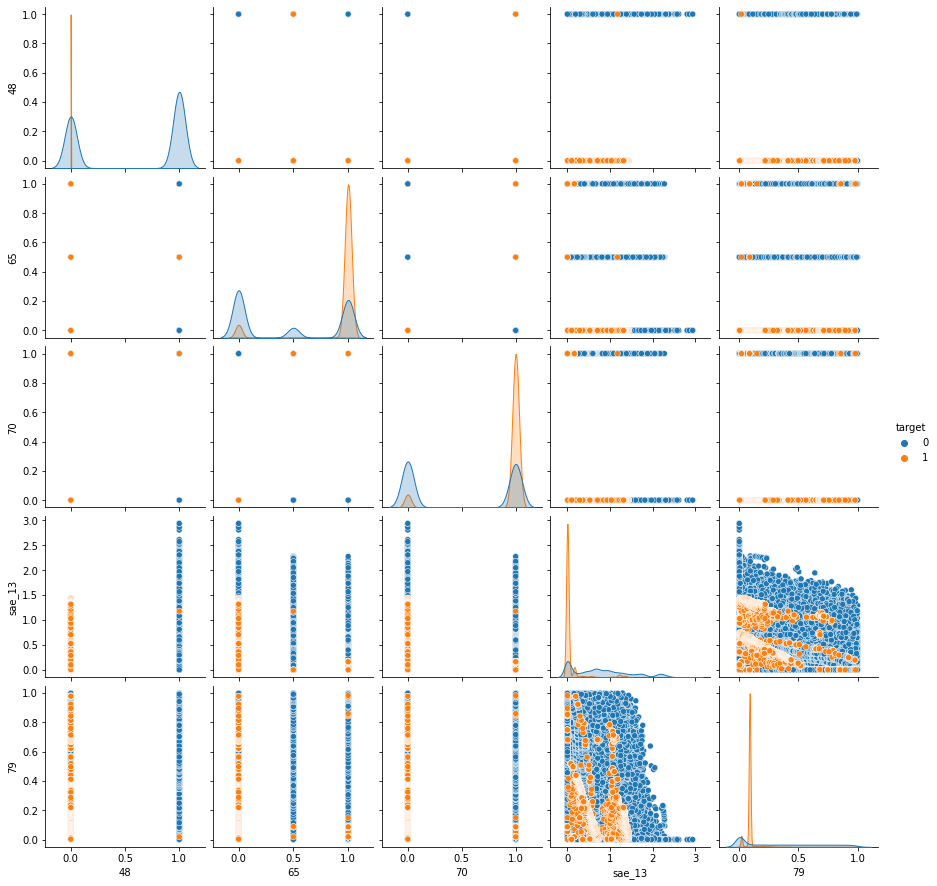

In [50]:
sb.pairplot(pairplot_data.iloc[:,5:], hue = 'target')

In [88]:
#Log reg on ICA optimise
X_train_best, X_test_best, features = select_features(X_train_ica, X_test_ica, Y_train, num_features = 10) #5 feats. better

# params_bayes = {'C': Real(0.1, 10, prior = 'log-uniform'),
#                 'solver': Categorical(['lbfgs', 'saga']),
#                 'penalty' : Categorical(['none', 'l2'])} 


# log_model = LogisticRegression(C = 0.1, penalty = 'none', solver = 'saga', tol = 1E-2, random_state = 7)

# # start = time.time()
# # clf = BayesSearchCV(log_model, params_bayes, n_iter = 15, cv = 2)
# # grid = clf.fit(X_train_best, Y_train)
# # end = time.time()
# # print('time:', end-start)
# # print(grid.best_params_)

# start = time.time()
# log_model.fit(X_train_best, Y_train)
# end = time.time()
# ttb = end-start

# cross_val = cross_val_score(log_model, X_train_best, Y_train, cv=2)
# cross_val_mean = cross_val.mean()
# print(cross_val_mean)

# start = time.time()
# log_preds = log_model.predict(X_test_best)
# end = time.time()
# ttp = end-start

# class_report, confusion_mat = test_score(log_model, X_test_best, Y_test)

results = [['Final log reg model on ICA', features.columns.values, cross_val_mean, class_report['accuracy'], confusion_mat[0][1], ttb, ttp]]

results_df = pd.DataFrame(results, columns = ['Name', 'features', 'training add', 'testing acc', 'False positives', 'time to build', 'time to predict'])
results_df.style

#model_overview.append(['Logreg opt 10 ica feats saga C0.2 tol1E-2 l2', features.columns.values, cross_val_mean, class_report['accuracy']])

# time: 78.41407942771912
# OrderedDict([('C', 0.1), ('penalty', 'none'), ('solver', 'lbfgs')])

,Name,features,training add,testing acc,False positives,time to build,time to predict
0,Final log reg model on ICA,[64 47 68 65 'ica_1' 48 44 70 6 79],0.954351,0.980726,604,2.250511,0.004004
